#Import Data

In [1]:
!gdown --id 14Yc3iHSFnY4k0G0QAikSSIRevJPx08Ke --output question.csv
!gdown --id 1hY32lCbt435R0qda_GoNOVFHRfSzn3Jx --output answerer.csv
!gdown --id 1-IWMGTcaEh-v_yjTLf0a-ievRCoRhvGc --output answerer_id.csv
!gdown --id 1_DJlkcJUtZkpomafImkakpJzC4PTuu-C --output answer.csv
!gdown --id 1ZhP9UUWSg5spmrGUdd1yIdpKytWmETNa --output users_ans.csv
!gdown --id 1D9b7ik8y9fccX-gVsoPawOfBUKBX_-GZ --output users_ask.csv
!gdown --id 1WFLvfTIFcXvq__1saG_guv6Z6c2yjWf8 --output users_tags.csv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=14Yc3iHSFnY4k0G0QAikSSIRevJPx08Ke
To: /content/question.csv
100% 104M/104M [00:01<00:00, 77.5MB/s] 
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1hY32lCbt435R0qda_GoNOVFHRfSzn3Jx
To: /content/answerer.csv
100% 27.7M/27.7M [00:00<00:00, 171MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: htt

In [2]:
import numpy as np
import pandas as pd
import gensim.models
import gensim.downloader as api
import multiprocessing
import keras.preprocessing.text as T
import matplotlib.pyplot as plt
import xgboost as xgb

from xgboost import XGBClassifier, plot_importance
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from gensim.models import word2vec
from gensim.models.doc2vec import TaggedDocument

import sklearn.metrics as metrics
from textblob import TextBlob
from sklearn import neighbors
from sklearn import utils
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [3]:
question = pd.read_csv("question.csv", delimiter = "\t")
answer = pd.read_csv("answer.csv")
answerer = pd.read_csv("answerer.csv", encoding = "ISO-8859-1")
answerer_id = pd.read_csv("answerer_id.csv")
users_ans = pd.read_csv("users_ans.csv")
users_ask = pd.read_csv("users_ask.csv")
users_tags = pd.read_csv("users_tags.csv")

##Embedding

In [4]:
#Tokenizer
#Use question and body to train two different embedding model accordingly
def tokenize_dataframe(data, target):
  body = target + "_body"
  tokenized = "tokenized_" + target

  data = data.astype({body: str}, errors='raise') 
  tokenized_list = []
  for i in range(data.shape[0]):
    tokenized_list.append(T.text_to_word_sequence(data[body][i]))
  data[tokenized] = tokenized_list
  return data

#Doc2vec
def embedding_doc_to_vec(data, mode, target):
	tokenized = "tokenized_" + target
	if mode == "train":
		documents = [TaggedDocument(words = doc, tags = [i]) for i, doc in enumerate(data[tokenized])]
		model = gensim.models.Doc2Vec(dm = 1, vector_size = 200, window = 5, min_count = 1, workers = 4, epochs = 10)
		model.build_vocab(documents)
		model.train(documents, total_examples = model.corpus_count, epochs = model.epochs)
	
	DocVec = []
	for i in range(len(data[tokenized])):
		doc_vec_each = model.infer_vector(data[tokenized][i], alpha = 0.025, epochs = 10)
		DocVec.append(doc_vec_each)

	output_df = pd.DataFrame(DocVec)
	normalized = (output_df - output_df.mean()) / output_df.std()
	if mode == "train":
		return normalized, model
	else:
		return normalized

#Model (純文字）

In [ ]:
ans_que_merge = answer.copy()
ans_que_merge = ans_que_merge.merge(question, left_on = "question_id", right_on = "question_id")

In [ ]:
#transfer sequence (list) of words to 200 dimensional vector
train_question_data = tokenize_dataframe(ans_que_merge, target = "question")
train_answer_data = tokenize_dataframe(ans_que_merge, target = "answer")

question_vec, question_doc2vec = embedding_doc_to_vec(train_question_data, mode = "train", target = "question")
answer_vec, answer_doc2vec = embedding_doc_to_vec(train_answer_data, mode = "train", target = "answer")

In [ ]:
result = pd.concat([question_vec, answer_vec], axis = 1)
result = result.set_axis([i for i in range(result.shape[1])], axis = 1, inplace=False)

In [ ]:
result_after = result.copy()

In [ ]:
#Use XGboost to classify
training_x = result_after.to_numpy()
training_y = [ans_que_merge["is_accepted"][i] for i in range(ans_que_merge.shape[0])]

#X : vector, y: label
X_train, X_test, y_train, y_test = train_test_split(training_x, training_y, test_size = 0.15, random_state = 21)
xg3 = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.08, max_depth = 6, n_estimators = 200)
xg3 = xg3.fit(X_train, y_train)
y_pred = xg3.predict(X_test)

accuracy_score:  0.7029633886061402


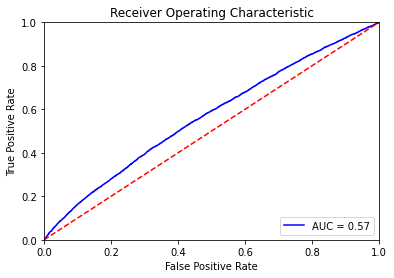

In [ ]:
print("accuracy_score: ",accuracy_score(y_test, y_pred))
# calculate the fpr and tpr for all thresholds of the classification
probs = xg3.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


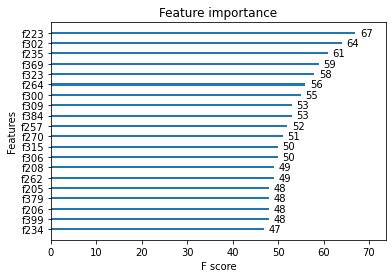

'\n1. f400: time_var\n2. f404: answerer_reputation\n3. f410: answer_count\n4. f411: question_count\n5. f412: reputation_change_year\n6. f409: vote\n'

In [ ]:
plot_importance(xg3, max_num_features = 20, grid = False) #answer time var, answer size, answer reputation is the top 3
plt.show()

"""
1. f400: time_var
2. f404: answerer_reputation
3. f410: answer_count
4. f411: question_count
5. f412: reputation_change_year
6. f409: vote
"""


#Model (純文字＋回答內容變數)

In [ ]:
ans_que_merge = answer.copy()
ans_que_merge = ans_que_merge.merge(question, left_on = "question_id", right_on = "question_id")
ans_que_merge = ans_que_merge.merge(users_ans, left_on = "answerer_id", right_on = "user_id" )

In [ ]:
#transfer sequence (list) of words to 200 dimensional vector
train_question_data = tokenize_dataframe(ans_que_merge, target = "question")
train_answer_data = tokenize_dataframe(ans_que_merge, target = "answer")

question_vec, question_doc2vec = embedding_doc_to_vec(train_question_data, mode = "train", target = "question")
answer_vec, answer_doc2vec = embedding_doc_to_vec(train_answer_data, mode = "train", target = "answer")

In [ ]:
result = pd.concat([question_vec, answer_vec], axis = 1)
result = result.set_axis([i for i in range(result.shape[1])], axis = 1, inplace=False)

In [ ]:
"""
add feature and feature normalization:
1. answer_creation_date - question_creation_date int
2. answer external link int
3. answer size int
4. question_code_size int
5. answerer_reputation int
"""

def normalize(col):
  col = (col - col.mean())/col.std()
  return col

result_after = result.copy()
result_after["time_var"] = ans_que_merge["answer_creation_date"]-ans_que_merge["question_creation_date"]
append_feature = ["answer_external_link","answer_size", "question_code_size", "answerer_reputation"]

for i in append_feature:
  result_after[i] = normalize(ans_que_merge[i])
result_after = result_after.fillna(value = 0)

In [ ]:
#Use XGboost to classify
training_x = result_after.to_numpy()
training_y = [ans_que_merge["is_accepted"][i] for i in range(ans_que_merge.shape[0])]

#X : vector, y: label
X_train, X_test, y_train, y_test = train_test_split(training_x, training_y, test_size = 0.15, random_state = 21)
xg3 = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.08, max_depth = 6, n_estimators = 200)
xg3 = xg3.fit(X_train, y_train)
y_pred = xg3.predict(X_test)

accuracy_score:  0.7090102785145889


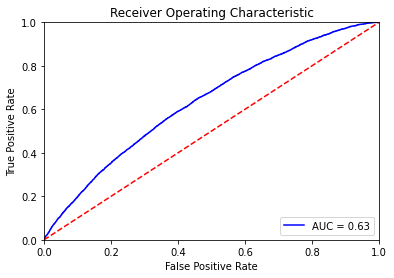

In [ ]:
print("accuracy_score: ",accuracy_score(y_test, y_pred))
# calculate the fpr and tpr for all thresholds of the classification
probs = xg3.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


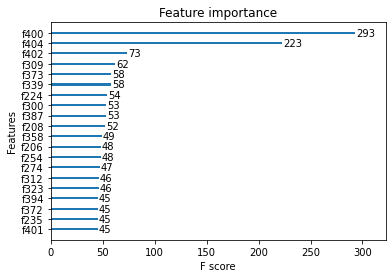

'\n1. f400: time_var\n2. f404: answerer_reputation\n3. f410: answer_count\n4. f411: question_count\n5. f412: reputation_change_year\n6. f409: vote\n'

In [ ]:
plot_importance(xg3, max_num_features = 20, grid = False) #answer time var, answer size, answer reputation is the top 3
plt.show()

"""
1. f400: time_var
2. f404: answerer_reputation
3. f410: answer_count
4. f411: question_count
5. f412: reputation_change_year
6. f409: vote
"""


#Model (純文字+回答者)

In [ ]:
ans_que_merge = answer.copy()
ans_que_merge = ans_que_merge.merge(question, left_on = "question_id", right_on = "question_id")
ans_que_merge = ans_que_merge.merge(users_ans, left_on = "answerer_id", right_on = "user_id" )

In [ ]:
#transfer sequence (list) of words to 200 dimensional vector
train_question_data = tokenize_dataframe(ans_que_merge, target = "question")
train_answer_data = tokenize_dataframe(ans_que_merge, target = "answer")

question_vec, question_doc2vec = embedding_doc_to_vec(train_question_data, mode = "train", target = "question")
answer_vec, answer_doc2vec = embedding_doc_to_vec(train_answer_data, mode = "train", target = "answer")

In [ ]:
result = pd.concat([question_vec, answer_vec], axis = 1)
result = result.set_axis([i for i in range(result.shape[1])], axis = 1, inplace=False)

In [ ]:
"""
add feature and feature normalization:
1. answer_creation_date - question_creation_date int
2. answer external link int
3. answer size int
4. question_code_size int
5. answerer_reputation int
"""

def normalize(col):
  col = (col - col.mean())/col.std()
  return col

result_after = result.copy()
result_after["time_var"] = ans_que_merge["answer_creation_date"]-ans_que_merge["question_creation_date"]
append_feature = ["all_badge","gold_badge","silver_badge", "bronze_badge", "vote", "answer_count", "question_count","reputation_change_year"]

for i in append_feature:
  result_after[i] = normalize(ans_que_merge[i])
result_after = result_after.fillna(value = 0)


In [ ]:
#Use XGboost to classify
training_x = result_after.to_numpy()
training_y = [ans_que_merge["is_accepted"][i] for i in range(ans_que_merge.shape[0])]

#X : vector, y: label
X_train, X_test, y_train, y_test = train_test_split(training_x, training_y, test_size = 0.15, random_state = 21)
xg3 = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.08, max_depth = 6, n_estimators = 200)
xg3 = xg3.fit(X_train, y_train)
y_pred = xg3.predict(X_test)

accuracy_score:  0.7096734084880637


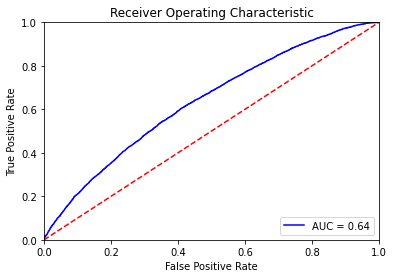

In [ ]:
print("accuracy_score: ",accuracy_score(y_test, y_pred))
# calculate the fpr and tpr for all thresholds of the classification
probs = xg3.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


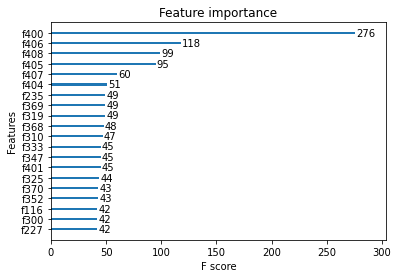

'\n1. f400: time_var\n2. f404: answerer_reputation\n3. f410: answer_count\n4. f411: question_count\n5. f412: reputation_change_year\n6. f409: vote\n'

In [ ]:
plot_importance(xg3, max_num_features = 20, grid = False) #answer time var, answer size, answer reputation is the top 3
plt.show()

"""
1. f400: time_var
2. f404: answerer_reputation
3. f410: answer_count
4. f411: question_count
5. f412: reputation_change_year
6. f409: vote
"""


#Model (純文字+回答內容變數+回答者)

In [5]:
ans_que_merge = answer.copy()
ans_que_merge = ans_que_merge.merge(question, left_on = "question_id", right_on = "question_id")
ans_que_merge = ans_que_merge.merge(users_ans, left_on = "answerer_id", right_on = "user_id" )

In [6]:
#transfer sequence (list) of words to 200 dimensional vector
train_question_data = tokenize_dataframe(ans_que_merge, target = "question")
train_answer_data = tokenize_dataframe(ans_que_merge, target = "answer")

question_vec, question_doc2vec = embedding_doc_to_vec(train_question_data, mode = "train", target = "question")
answer_vec, answer_doc2vec = embedding_doc_to_vec(train_answer_data, mode = "train", target = "answer")

In [7]:
result = pd.concat([question_vec, answer_vec], axis = 1)
result = result.set_axis([i for i in range(result.shape[1])], axis = 1, inplace=False)

In [8]:
"""
add feature and feature normalization:
1. answer_creation_date - question_creation_date int
2. answer external link int
3. answer size int
4. question_code_size int
5. answerer_reputation int
"""

def normalize(col):
  col = (col - col.mean())/col.std()
  return col

def TextBlob_Vec(doc):
  blob = TextBlob(doc)
  doc_sentiment = 0
  for sentence in blob.sentences:
      doc_sentiment += sentence.sentiment.polarity
  return doc_sentiment

result_after = result.copy()
result_after[result_after.shape[0]] = [TextBlob_Vec(train_answer_data["answer_original"][i]) for i in range(train_answer_data.shape[0])]

result_after["time_var"] = ans_que_merge["answer_creation_date"]-ans_que_merge["question_creation_date"]
append_feature = ["answer_external_link","answer_size", "question_code_size", "answerer_reputation", "all_badge", 
                  "gold_badge","silver_badge", "bronze_badge", "vote", "answer_count", "question_count","reputation_change_year"]

for i in append_feature:
  result_after[i] = normalize(ans_que_merge[i])
result_after = result_after.fillna(value = 0)

In [9]:
#Use XGboost to classify
training_x = result_after.to_numpy()
training_y = [ans_que_merge["is_accepted"][i] for i in range(ans_que_merge.shape[0])]

#X : vector, y: label
X_train, X_test, y_train, y_test = train_test_split(training_x, training_y, test_size = 0.15, random_state = 21)
xg3 = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.08, max_depth = 6, n_estimators = 200)
xg3 = xg3.fit(X_train, y_train)
y_pred = xg3.predict(X_test)

accuracy_score:  0.709507625994695


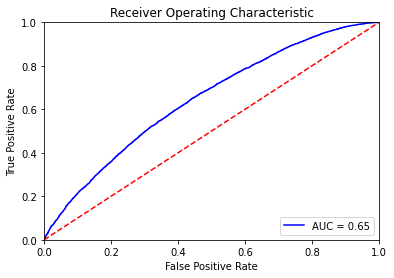

In [10]:
print("accuracy_score: ",accuracy_score(y_test, y_pred))
# calculate the fpr and tpr for all thresholds of the classification
probs = xg3.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


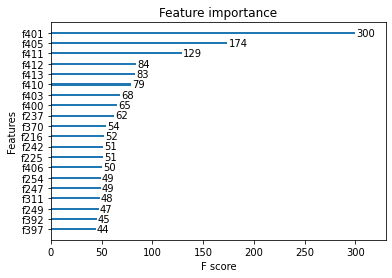

'\n1. f400: time_var\n2. f404: answerer_reputation\n3. f410: answer_count\n4. f411: question_count\n5. f412: reputation_change_year\n6. f409: vote\n'

In [11]:
plot_importance(xg3, max_num_features = 20, grid = False) #answer time var, answer size, answer reputation is the top 3
plt.show()

"""
1. f400: time_var
2. f404: answerer_reputation
3. f410: answer_count
4. f411: question_count
5. f412: reputation_change_year
6. f409: vote
"""

#Predict

In [ ]:
n_cnt = 0
cnt = 0
for i in range(len(y_pred)):
  if y_pred[i] != False:
    cnt += 1
  else:
    n_cnt += 1
print(cnt, n_cnt, cnt/ (cnt+n_cnt))

961 23167 0.03982924403183024


In [ ]:
n_cnt = 0
cnt = 0
for i in range(len(y_test)):
  if y_test[i] != False:
    cnt += 1
  else:
    n_cnt += 1
print(cnt, n_cnt, cnt/ (cnt+n_cnt))

7033 17095 0.29148706896551724
